<a href="https://colab.research.google.com/github/juwetta/DLI_Group-B/blob/main/LGBM_ALGORITHM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Load CSV from Google Drive

In [6]:
import pandas as pd

# Replace this with your actual path if different
df = pd.read_csv('/content/drive/MyDrive/phishing_combined.csv')

# Confirm the data loaded
print(df.shape)
print(df['status'].value_counts())
df.head()


(11430, 89)
status
phishing      5715
legitimate    5715
Name: count, dtype: int64


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,https://bcpzonasegurabeta.viabcp.com/#/iniciar...,55,28,0,2,1,0,0,0,0,...,1,1,0,278,7391,6763,0,0,4,phishing
1,https://www.horstmicket.com/images/img/,39,19,0,2,0,0,0,0,0,...,1,0,0,267,3386,0,0,1,2,phishing
2,http://wefbee.com/autoliker,27,10,0,1,0,0,0,0,0,...,0,0,0,392,1799,140317,0,0,2,phishing
3,https://www.cutiefive.net/,26,17,0,2,0,0,0,0,0,...,0,1,0,168,1658,3124494,0,0,3,legitimate
4,http://www.klassekampen.no/,27,19,0,2,0,0,0,0,0,...,0,1,0,0,7556,614699,0,0,5,legitimate


# Step 2: Preprocess the Dataset

In [7]:
# 🧹 STEP 4: Preprocess the data

# Encode target label
df['label'] = df['status'].apply(lambda x: 1 if x == 'phishing' else 0)
df.drop(columns=['status'], inplace=True)

# One-hot encode categorical columns
df = pd.get_dummies(df)
df.fillna(0, inplace=True)

# Ensure unique column names
from collections import Counter

def clean_columns(df):
    df.columns = df.columns.astype(str)
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)
    counts = Counter()
    new_cols = []
    for col in df.columns:
        counts[col] += 1
        new_cols.append(f"{col}_{counts[col]}" if counts[col] > 1 else col)
    df.columns = new_cols
    return df

df = clean_columns(df)
print("✅ Columns cleaned. Total columns:", len(df.columns))


✅ Columns cleaned. Total columns: 11517


#Step 3: Train/Test Split

In [8]:
# 🧠 STEP 5: Split the dataset
from sklearn.model_selection import train_test_split

X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Dataset split. Train size:", X_train.shape, "Test size:", X_test.shape)


✅ Dataset split. Train size: (9144, 11516) Test size: (2286, 11516)


#Step 4: Train the Model

In [4]:
# 🏋️ STEP 6: Train LGBMClassifier
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
print("✅ Model trained successfully.")


[LightGBM] [Info] Number of positive: 4572, number of negative: 4572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4888
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
✅ Model trained successfully.


#Step 5: Evaluate the Model

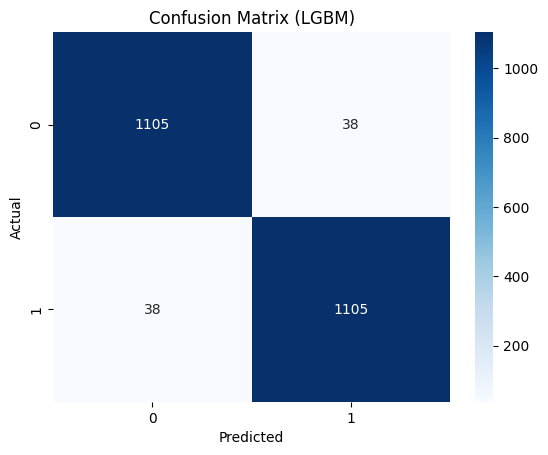

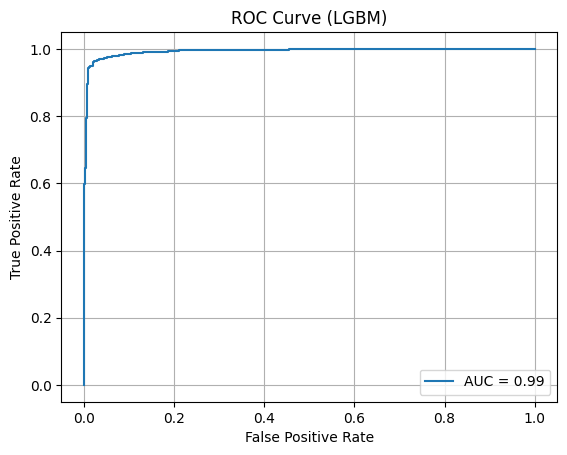

F1 Score: 0.9667541557305337
Accuracy: 0.9667541557305337
Precision: 0.9667541557305337
Recall: 0.9667541557305337
ROC-AUC Score: 0.9929664303773054
✅ Verdict: Achieved F1 = 0.97, AUC = 0.99 — Target Met ✅


In [5]:
# 📊 STEP 7: Evaluate the model
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (LGBM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LGBM)")
plt.legend()
plt.grid(True)
plt.show()

# Print Evaluation Scores
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC-AUC Score:", auc_score)
print(f"✅ Verdict: Achieved F1 = {f1:.2f}, AUC = {auc_score:.2f} — Target {'Met ✅' if f1 >= 0.90 else 'Not Met ❌'}")
